# Interpretable Object Detection

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import brambox as bb
import lightnet as ln
import interpretability as ip

## Settings and paths

In [2]:
# Settings
bb.logger.setConsoleLevel('ERROR')             # Only show error log messages

# Setting device
device = torch.device('cpu')
if torch.cuda.is_available():
    print('CUDA enabled')
    device = torch.device('cuda')
else:
    print('CUDA not available')
    
# Path variables
network_path = 'cfg/yolo.py'
annos_path = 'data/VOCdevkit/VOC2007/Annotations/'
weights_path = 'weights/yolov2-voc.pt'

CUDA enabled


## Picking interesting images

In [3]:
# Load annotations
anno = bb.io.load('pandas', 'data/annotations.pkl')
det = bb.io.load('pandas', 'data/detections_all.h5')

# Variables
detection_threshold = 0.5

my_class = 'sheep' # Which class to look at
# aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor

anno = anno[anno['class_label'] == my_class]
det = det[det['class_label'] == my_class]

# Filter detections based on threshold (computed in previous step from F1-curve)
filtered_det = det[det.confidence >= detection_threshold].copy()

# Compute TP,FP
tpfp_det = bb.stat.match_det(filtered_det, anno, 0.1, ignore=bb.stat.IgnoreMethod.SINGLE)
# match_det() returns detections with a 'tp' and 'fp' column.
print('TP FP:')
tpfp_det = tpfp_det[tpfp_det['fp']]
tpfp_det = tpfp_det.drop_duplicates(['image'])
display(tpfp_det.sort_values(['confidence'], ascending=False))
chosen_images = tpfp_det.image

# Compute FN
fn_anno = bb.stat.match_anno(filtered_det, anno, 0.5, ignore=bb.stat.IgnoreMethod.SINGLE)
# match_anno() returns annotations with a 'detection' column that has the index of the matched detection
# We use this to filter unmatched annotations (NaN as index)
fn_anno = fn_anno[fn_anno.detection.isnull()]
fn_anno = fn_anno[~fn_anno['ignore']]
fn_anno = fn_anno.drop_duplicates(['image'])
print('FN:')
display(fn_anno)
"""chosen_images = chosen_images.append(fn_anno.image)"""
#chosen_images = fn_anno.image

TP FP:


,image,class_label,id,x_top_left,y_top_left,width,height,confidence,tp,fp
29428,VOC2007/JPEGImages/001306,sheep,NaN,171.200569,133.564380,111.979943,76.833775,0.855539,False,True
71503,VOC2007/JPEGImages/003152,sheep,NaN,229.197851,54.188141,264.966121,278.085892,0.800626,False,True
3584,VOC2007/JPEGImages/000175,sheep,NaN,-0.679087,49.010506,70.480072,155.383569,0.792055,False,True
155044,VOC2007/JPEGImages/006815,sheep,NaN,191.983021,136.704738,227.079575,107.757147,0.785990,False,True
52251,VOC2007/JPEGImages/002326,sheep,NaN,179.328020,136.277456,44.087846,46.315569,0.782448,False,True
123934,VOC2007/JPEGImages/005452,sheep,NaN,167.019441,123.347668,185.979495,102.086397,0.716940,False,True
76102,VOC2007/JPEGImages/003361,sheep,NaN,214.013521,253.465689,52.098797,34.097064,0.697774,False,True
168974,VOC2007/JPEGImages/007462,sheep,NaN,10.006506,153.239690,38.899018,45.119295,0.691484,False,True
64153,VOC2007/JPEGImages/002837,sheep,NaN,171.531751,115.665913,174.580207,193.860164,0.684157,False,True
99420,VOC2007/JPEGImages/004375,sheep,NaN,102.988647,163.491231,75.971888,60.142347,0.643784,False,True


FN:


,image,class_label,id,x_top_left,y_top_left,width,height,occluded,truncated,lost,difficult,ignore,detection,criteria
275,VOC2007/JPEGImages/000176,sheep,0,3.153846,208.000000,82.0,71.0,1.0,0.0,False,False,False,NaN,0.0
1309,VOC2007/JPEGImages/000875,sheep,0,278.000000,171.000000,27.0,32.0,0.0,0.0,False,False,False,NaN,0.0
2141,VOC2007/JPEGImages/001416,sheep,0,1.000000,107.201923,121.0,144.0,1.0,0.0,False,False,False,NaN,0.0
2247,VOC2007/JPEGImages/001477,sheep,0,13.000000,1.000000,65.0,84.0,0.0,0.0,False,False,False,NaN,0.0
2456,VOC2007/JPEGImages/001625,sheep,0,136.000000,187.201923,100.0,74.0,1.0,0.0,False,False,False,NaN,0.0
2536,VOC2007/JPEGImages/001671,sheep,0,206.000000,154.000000,53.0,60.0,1.0,0.0,False,False,False,NaN,0.0
3174,VOC2007/JPEGImages/002121,sheep,0,143.000000,96.000000,100.0,153.0,0.0,0.0,False,False,False,NaN,0.0
3187,VOC2007/JPEGImages/002133,sheep,0,94.000000,244.000000,264.0,132.0,1.0,0.0,False,False,False,NaN,0.0
3192,VOC2007/JPEGImages/002137,sheep,0,206.000000,249.000000,93.0,68.0,1.0,0.0,False,False,False,NaN,0.0
4217,VOC2007/JPEGImages/002802,sheep,0,38.000000,79.000000,338.0,147.0,1.0,0.0,False,False,False,NaN,0.0


'chosen_images = chosen_images.append(fn_anno.image)'

## Run Backprogation

INFO       Loading weights from file [weights/yolov2-voc.pt]


LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)
LeakyReLU(negative_slope=0.1)


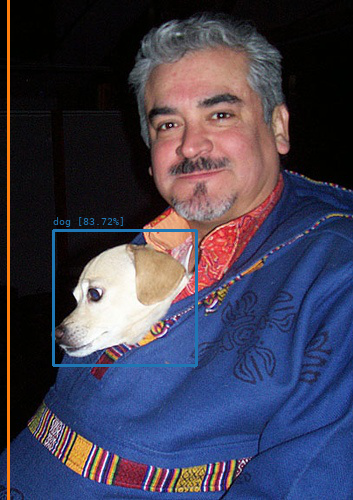

Detections:


,image,class_label,x_top_left,y_top_left,width,height,confidence,anchor_box,status
0,VOC2007/JPEGImages/000001,person,67.882812,-3.148651,293.986755,428.566864,0.92613,4.0,FP
1,VOC2007/JPEGImages/000001,dog,105.593132,191.978592,119.163956,112.357025,0.83719,1.0,FP


In [4]:
# Initialize network and load weights
params = ln.engine.HyperParameters.from_file(network_path)
params.network.load(weights_path)

# Vanilla backprop
VBP = ip.backprop.VanillaBackprop(params, device)

# Guided backprop
GBP = ip.backprop.GuidedBackprop(params, device)

gradients_as_arr_list = []
count_list = []
img_tf_list = []
chosen_images = ['VOC2007/JPEGImages/000001']

for image in chosen_images:
    # New path
    new_path = annos_path + image.split('/')[-1] + '.xml'
    
    # Load annos
    annos = bb.io.load('anno_pascalvoc', new_path, ip.identify)
    annos = annos[annos['class_label'] == my_class]
    
    # Get detections
    det_img, detections = ip.run_detect(params, new_path, device, detection_threshold)
    display(ip.utils.show_image(det_img))
    detections.image = image
    detections.image = detections.image.astype('category')
    #detections = detections[detections['class_label'] == my_class]
    
    # Run model
    img_tf, annos = ip.transform(params, annos, new_path)

    # Compute TP,FP
    tpfp_det = bb.stat.match_det(detections, annos, 0.5, ignore=bb.stat.IgnoreMethod.SINGLE)
    # match_det() returns detections with a 'tp' and 'fp' column.

    # Compute FN
    fn_anno = bb.stat.match_anno(detections, annos, 0.5, ignore=bb.stat.IgnoreMethod.SINGLE)
    # match_anno() returns annotations with a 'detection' column that has the index of the matched detection
    # We use this to filter unmatched annotations (NaN as index)
    fn_anno = fn_anno[fn_anno.detection.isnull()]
    
    # Add status column
    tpfp_det['status'] = 'FP'                     # Make all boxes FP
    tpfp_det.loc[tpfp_det.tp, 'status'] = 'TP'  # Make TP boxes TP
    fn_anno['status'] = 'FN'                     # Make FN boxes FN
    
    # Add extra columns to fn_anno to be able to combine dataframes
    fn_anno['anchor_box'] = ''
    fn_anno['confidence'] = ''

    # Only keep necessary columns (to be able to combine dataframes)
    boxes1 = tpfp_det[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'confidence', 'anchor_box', 'status']]
    boxes2 = fn_anno[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'confidence', 'anchor_box', 'status']]

    # Concatenate dataframes
    boxes = bb.util.concat([boxes1, boxes2], sort=False, ignore_index=True)
    
    print('Detections:')
    display(boxes)

    # Generate gradients
    gradients_as_arr = VBP.generate_gradients(params, img_tf, device, boxes, True, True)
    img_tf_list.append(img_tf.data.cpu().numpy()[0])
    count_list.append(len(gradients_as_arr))
    for gradient in gradients_as_arr:
        gradients_as_arr_list.append(gradient)
        
    # Generate gradients
    gradients_as_arr = GBP.generate_gradients(params, img_tf, device, boxes, True, True)
    for gradient in gradients_as_arr:
        gradients_as_arr_list.append(gradient)

## Show images on screen

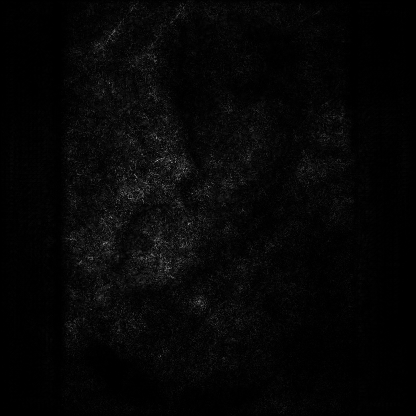

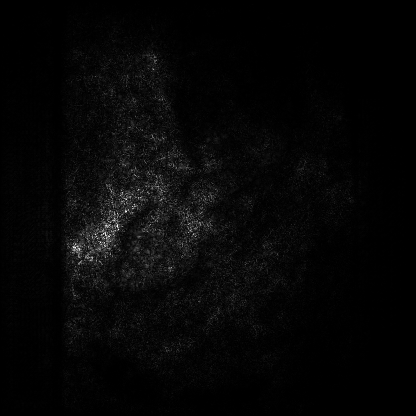

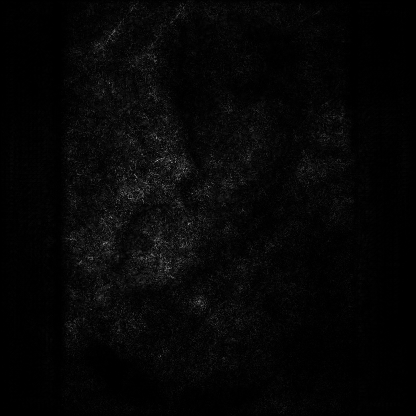

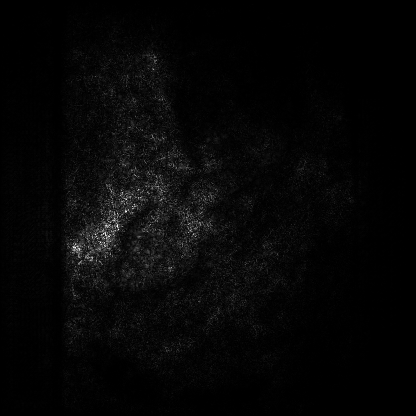

'    img_tf_show = ip.utils.show_image(img_tf_list[count2])\n    img_tf_show.paste(img, (0, 0), img)\n    display(img_tf_show)\n    count1 += 1'

In [5]:
# Normalize to grayscale and show images
gradients_list = ip.utils.normalize(gradients_as_arr_list, True)
count1 = 0
count2 = 0

for gradient in gradients_list:
    if count1 == count_list[count2]:
        count2 += 1
        count1 = 0
    img = ip.utils.show_image(gradient).convert("L")
    display(img)
'''    img_tf_show = ip.utils.show_image(img_tf_list[count2])
    img_tf_show.paste(img, (0, 0), img)
    display(img_tf_show)
    count1 += 1'''

# End